# Load data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np

# Load Training data
images = np.load('/content/drive/MyDrive/Datasets/UDIAT/Fused/images.npy')
labels = np.load('/content/drive/MyDrive/Datasets/UDIAT/Fused/labels.npy')
classes = ["Benign", "Malignant"]

In [ ]:
from sklearn.model_selection import train_test_split

# Define the ratios for splitting
train_ratio = 0.7
val_ratio = 0.1
test_ratio = 0.2

# Split the data into training, validation, and test sets
x_train, x_temp, y_train, y_temp = train_test_split(
    images, labels, test_size=1 - train_ratio, random_state=42)

x_val, x_test, y_val, y_test = train_test_split(
    x_temp, y_temp, test_size=test_ratio / (test_ratio + val_ratio), random_state=42)

In [ ]:
# Print the number of samples in each set
print(f"Number of samples in training set: {len(x_train)}")
print(f"Number of samples in validation set: {len(x_val)}")
print(f"Number of samples in test set: {len(x_test)}")

Number of samples in training set: 151
Number of samples in validation set: 22
Number of samples in test set: 44


In [ ]:
# Print the number of samples in each class within each set
for set_name, x_set, y_set in [("Training", x_train, y_train), ("Validation", x_val, y_val), ("Test", x_test, y_test)]:
    print(f"Samples in {set_name} set:")
    for class_label, class_name in enumerate(classes):
        num_samples = np.sum(y_set == class_label)
        print(f"  Class '{class_name}': {num_samples}")


Samples in Training set:
  Class 'Benign': 77
  Class 'Malignant': 74
Samples in Validation set:
  Class 'Benign': 11
  Class 'Malignant': 11
Samples in Test set:
  Class 'Benign': 21
  Class 'Malignant': 23


In [ ]:
from sklearn.preprocessing import LabelBinarizer
# Use LabelBinarizer for one-hot encoding
label_binarizer = LabelBinarizer()
y_train = label_binarizer.fit_transform(y_train)
y_val = label_binarizer.fit_transform(y_val)
y_test = label_binarizer.fit_transform(y_test)

In [ ]:
# Print the number of samples in each set
print(f"Shape of labels in training set: {np.shape(y_train)}")
print(f"Shape of labels in validation set: {np.shape(y_val)}")
print(f"Shape of labels in test set: {np.shape(y_test)}")

Shape of labels in training set: (151, 1)
Shape of labels in validation set: (22, 1)
Shape of labels in test set: (44, 1)


## Plot few random samples

In [ ]:
# Define a function to plot random samples of benign and malignant images
import matplotlib.pyplot as plt
def plot_random_samples(images, labels, class_name, num_samples=3):
    # Get indices of images with the specified class
    class_indices = np.where(labels == class_name)[0]

    # Randomly select num_samples indices
    random_indices = np.random.choice(class_indices, num_samples, replace=False)

    # Create a subplots grid
    fig, axes = plt.subplots(1, num_samples, figsize=(6, 4))

    for i, idx in enumerate(random_indices):
        ax = axes[i]
        ax.imshow(images[idx])
        ax.set_title(f'Sample {i+1}')
        ax.axis('off')

    plt.show()

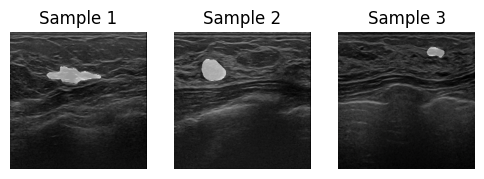

In [ ]:
# Plot 3 random samples of benign images from training data
plot_random_samples(images, labels, class_name=0, num_samples=3)

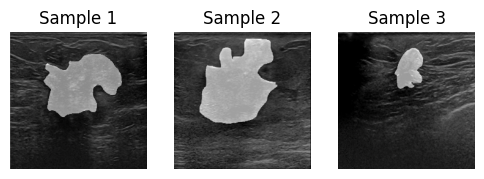

In [ ]:
# Plot 3 random samples of malignant images from training data
plot_random_samples(images, labels, class_name=1, num_samples=3)

# Build and Compile Model

In [ ]:
from keras.applications import MobileNet
import tensorflow as tf

# MobileNet Model
def create_model(SIZE):
  model =  MobileNet(weights='imagenet', include_top=False, input_shape=(SIZE, SIZE, 3))
  stringlist = []
  model.summary(print_fn=lambda x: stringlist.append(x))
  short_model_summary = "\n".join(stringlist)
  print(short_model_summary)
  for layer in model.layers:
    layer.trainable = False
  # Flatten the output layer to 1 dimension
  x = tf.keras.layers.Flatten()(model.output)

  # Add a fully connected layer with 512 hidden units and ReLU activation
  x = tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)

  # Add a dropout rate of 0.3
  x = tf.keras.layers.Dropout(0.3)(x)

  # Add a batch normalization layer
  x = tf.keras.layers.BatchNormalization()(x)

  x = tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)

  # Add a dropout rate of 0.2
  x = tf.keras.layers.Dropout(0.2)(x)

  # Add a batch normalization layer
  x = tf.keras.layers.BatchNormalization()(x)

  # Add a final sigmoid layer for classification
  output = tf.keras.layers.Dense(1 , activation='sigmoid')(x)

  model = tf.keras.Model(model.input, output)

  return model

In [ ]:
# Plot training history
import matplotlib.pyplot as plt
def plot_history(history=None):
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    epochsn = np.arange(1, len(train_loss)+1)
    plt.figure(figsize = (20,7))

    plt.subplot(1,3,1)
    plt.plot(epochsn,train_loss, 'b', label='Training Loss')
    plt.plot(epochsn,val_loss, 'r', label='Validation Loss')
    plt.grid(color='gray', linestyle='--')
    plt.legend()
    plt.title('Training Loss vs Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')

    plt.subplot(1,3,2)
    plt.plot(epochsn, train_acc, 'b', label='Training Accuracy')
    plt.plot(epochsn, val_acc, 'r', label='Validation Accuracy')
    plt.grid(color='gray', linestyle='--')
    plt.legend()
    plt.title('Training Accuracy vs Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.savefig("Learning_Curves.png", dpi=300)
    plt.show()

In [ ]:
# Create the final model
SIZE = 224
model = create_model(SIZE)

17225924/17225924 [==============================] - 0s 0us/step
Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 112, 112, 32)      128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 112, 112, 32)      288       
 )                                                               
                                                 

In [ ]:
# Add early stopping and reduce learning rate callbacks
mc = tf.keras.callbacks.ModelCheckpoint("trained_model.h5", monitor='val_accuracy', mode='max',verbose=1, save_best_only=True)
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, restore_best_weights=True, patience=20)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

In [ ]:
# Compile the Model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
stringlist = []
model.summary(print_fn=lambda x: stringlist.append(x))
short_model_summary = "\n".join(stringlist)
print(short_model_summary)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 112, 112, 32)      128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 112, 112, 32)      288       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, 112, 112, 32)      128   

# Train Model

In [ ]:
# Apply some augmentation to control overfitting
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rotation_range=15, width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
datagen.fit(images)

train_generator = datagen.flow(x=x_train, y=y_train, batch_size=32)

In [ ]:
# Train the Model
from datetime import datetime
start = datetime.now()
model_history = model.fit(train_generator, steps_per_epoch=len(x_train) // 32, batch_size=32, epochs=200, validation_data=(x_val, y_val), callbacks=[es, mc, reduce_lr])
stop = datetime.now()

Epoch 1/200
4/4 [==============================] - ETA: 0s - loss: 12.7557 - accuracy: 0.7059
Epoch 1: val_accuracy improved from -inf to 0.59091, saving model to trained_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4/4 [==============================] - 17s 1s/step - loss: 12.7557 - accuracy: 0.7059 - val_loss: 14.4913 - val_accuracy: 0.5909 - lr: 0.0010
Epoch 2/200
4/4 [==============================] - ETA: 0s - loss: 10.5322 - accuracy: 0.8235
Epoch 2: val_accuracy improved from 0.59091 to 0.81818, saving model to trained_model.h5
4/4 [==============================] - 3s 940ms/step - loss: 10.5322 - accuracy: 0.8235 - val_loss: 11.2097 - val_accuracy: 0.8182 - lr: 0.0010
Epoch 3/200
4/4 [==============================] - ETA: 0s - loss: 9.8216 - accuracy: 0.8828
Epoch 3: val_accuracy improved from 0.81818 to 0.86364, saving model to trained_model.h5
4/4 [==============================] - 4s 1s/step - loss: 9.8216 - accuracy: 0.8828 - val_loss: 10.4146 - val_accuracy: 0.8636 - lr: 0.0010
Epoch 4/200
4/4 [==============================] - ETA: 0s - loss: 9.4429 - accuracy: 0.8655
Epoch 4: val_accuracy did not improve from 0.86364
4/4 [==============================] - 2s 397ms/step - loss: 9.44

In [ ]:
# Print the Training Time

training_time = stop - start
print('Model training time is :', training_time)

Model training time is : 0:04:32.458639


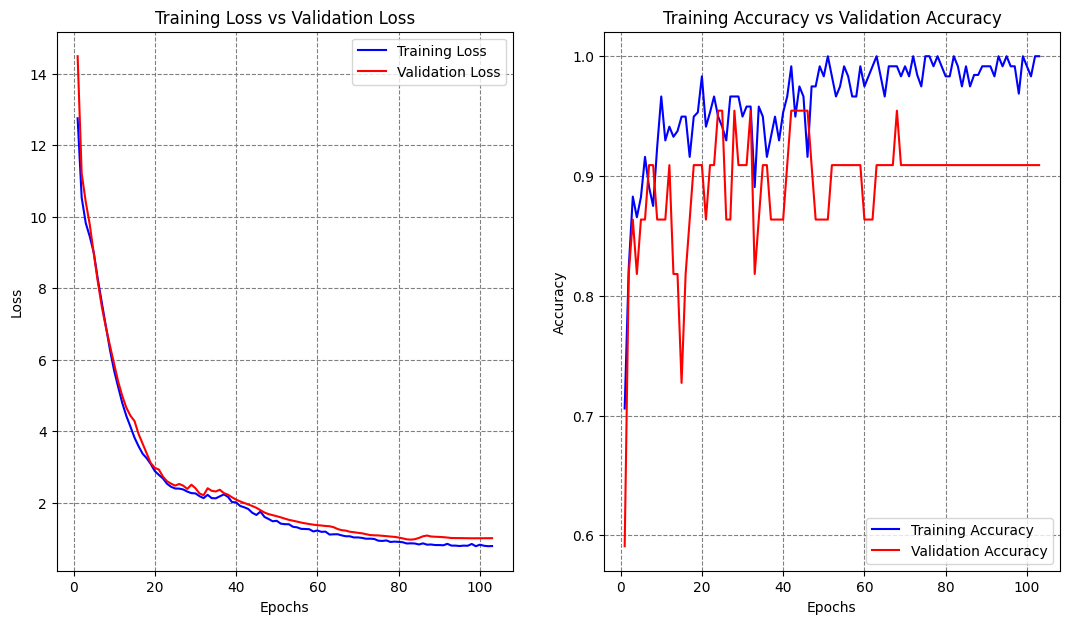

In [ ]:
# Plot the history
plot_history(model_history)

# Evaluate Model on Test data

In [ ]:
# Make predictions on the test set
model = tf.keras.models.load_model('/content/trained_model.h5')
y_pred = model.predict(x_test)

2/2 [==============================] - 1s 409ms/step


In [ ]:
# Calculate scores
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
accuracy = accuracy_score(y_test, y_pred.round())
sensitivity = recall_score(y_test, y_pred.round())
specificity = recall_score(y_test, y_pred.round(), pos_label=0)
f1 = f1_score(y_test, y_pred.round())
roc = roc_auc_score(y_test, y_pred)

In [ ]:
# Print the results
print("scores")
print("==================================================")
print("Accuracy score: %.4f" % (accuracy))
print("Sensitivity score: %.4f" % (sensitivity))
print("Specificity score: %.4f" % (specificity))
print("F1 score: %.4f" % (f1))
print("roc_auc score: %.4f" % (roc))
print("==================================================")

scores
Accuracy score: 0.9091
Sensitivity score: 0.8696
Specificity score: 0.9524
F1 score: 0.9091
roc_auc score: 0.9482


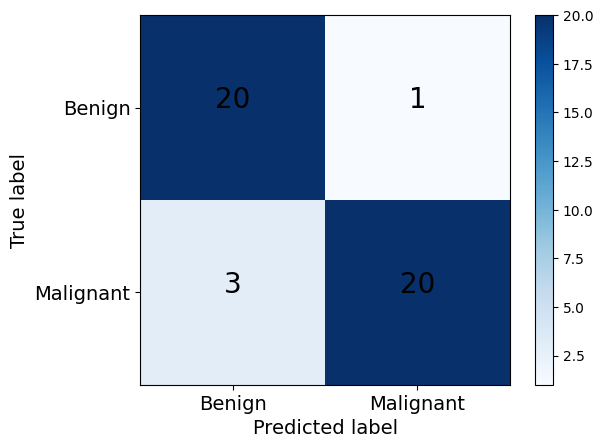

In [ ]:
# Plot Confusion Matrix
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(y_true, y_pred):

    # Create a confusion matrix
    y_pred_binary = y_pred.round()

    cm = confusion_matrix(y_true, y_pred_binary)

    # Plot the confusion matrix as a heatmap
    plt.imshow(cm, cmap=plt.cm.Blues)
    plt.ylabel('True label', fontsize=14)
    plt.xlabel('Predicted label', fontsize=14)
    plt.xticks([0, 1], ['Benign', 'Malignant'], fontsize=14)
    plt.yticks([0, 1], ['Benign', 'Malignant'], fontsize=14)
    plt.colorbar()

    # Add the values inside the cells
    for i in range(2):
        for j in range(2):
            plt.text(j, i, cm[i, j],
                     fontsize=20,  # specify the desired font size
                     horizontalalignment='center',
                     color='black')
    # Show the plot
    plt.savefig("Confusion_Matrix.png", dpi=300)
    plt.show()
plot_confusion_matrix(y_test, y_pred)

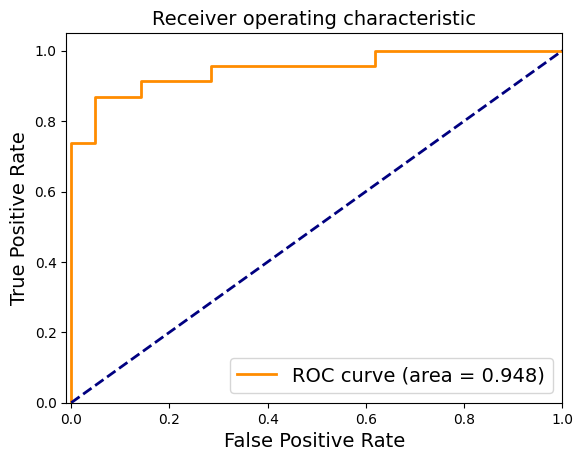

In [ ]:
# Plot ROC Curve
from sklearn.metrics import roc_curve, auc
def plot_roc_curve(y_true, y_pred):
    # Calculate the false positive rate and true positive rate for the ROC curve
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)

    # Plot the ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.3f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([-0.01, 1.0])
    plt.ylim([0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.title('Receiver operating characteristic', fontsize=14)
    plt.legend(loc="lower right", fontsize=14)
    plt.savefig("ROC_Curve.png", dpi=300)
    plt.show()

plot_roc_curve(y_test, y_pred)

# Feature Extraction

In [ ]:
# Load the pre-trained model
model = tf.keras.models.load_model('/content/trained_model.h5')

# Get the total number of layers in the model
total_layers = len(model.layers)
print("Total Layers in the Model are: ", total_layers)

# Define the index of the layer for feature extraction (second-to-last layer in this case)
feature_extraction_layer_index = total_layers - 7

# Get the name of the feature extraction layer
feature_extraction_layer_name = model.layers[feature_extraction_layer_index].name
print("Name of the Feature Extraction Layer: ", feature_extraction_layer_name)


# Specify the layers from which you want to extract features
feature_extraction_model = tf.keras.Model(inputs=model.input, outputs=model.get_layer(feature_extraction_layer_name).output)

print("Extracting features from images...................")
# Extract features from images
features = feature_extraction_model.predict(images)

Total Layers in the Model are:  94
Name of the Feature Extraction Layer:  dense
Extracting features from images...................
7/7 [==============================] - 1s 100ms/step


In [ ]:
# Check the shape of the feature arrays
print("Shape of features:", features.shape)

Shape of features: (217, 512)


In [ ]:
# Save the feature arrays as numpy arrays
np.save('features.npy', features)

# Visualize Extracted Features

## Using PCA

In [ ]:
from sklearn.decomposition import PCA

# Create a PCA model with the desired number of components (e.g., 2 for 2D visualization)
pca = PCA(n_components=2)

# Fit the PCA model to the features and transform them to the lower-dimensional space
reduced_features = pca.fit_transform(features)


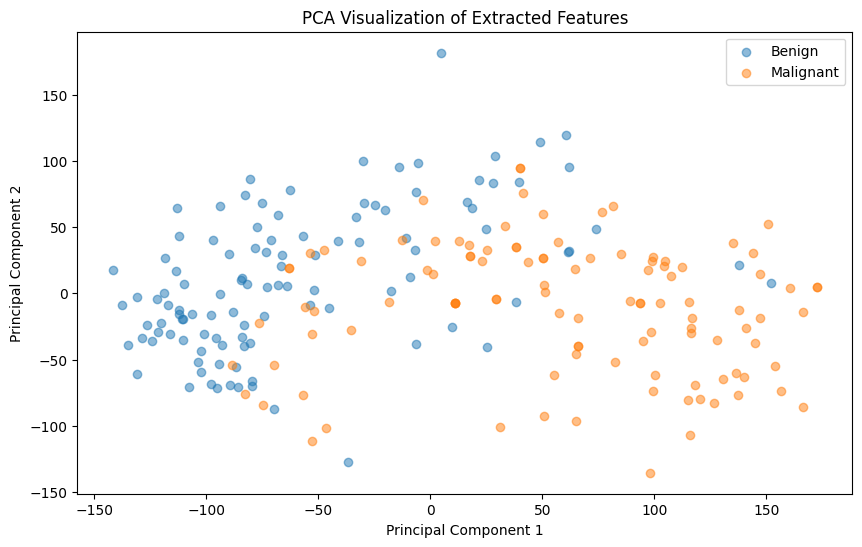

In [ ]:
import matplotlib.pyplot as plt

# Assuming labels contains the true labels (0 for Benign, 1 for Malignant)
plt.figure(figsize=(10, 6))
plt.scatter(reduced_features[labels == 0, 0], reduced_features[labels == 0, 1], label='Benign', alpha=0.5)
plt.scatter(reduced_features[labels == 1, 0], reduced_features[labels == 1, 1], label='Malignant', alpha=0.5)
plt.legend()
plt.title('PCA Visualization of Extracted Features')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()


## Using t-SNE

Apply t-SNE to reduce the dimensionality of your extracted features.

In [ ]:
from sklearn.manifold import TSNE

# Create a t-SNE model with the desired number of dimensions (e.g., 2 for 2D visualization)
tsne = TSNE(n_components=2, perplexity=30, random_state=42)

# Fit the t-SNE model to the features and transform them to the lower-dimensional space
reduced_features = tsne.fit_transform(features)


Adjust the perplexity parameter to control the balance between preserving global and local structure in the visualization. You may need to experiment with different values to find the most suitable one for your data.

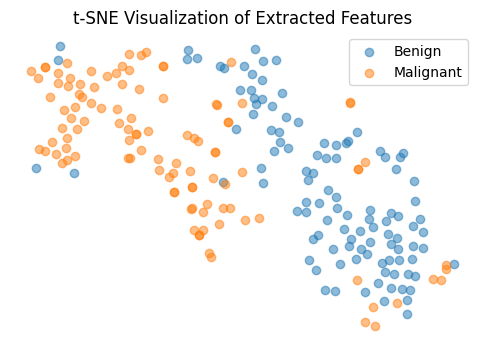

In [ ]:
# Assuming labels contains the true labels (0 for Benign, 1 for Malignant)
plt.figure(figsize=(6, 4))
plt.scatter(reduced_features[labels == 0, 0], reduced_features[labels == 0, 1], label='Benign', alpha=0.5)
plt.scatter(reduced_features[labels == 1, 0], reduced_features[labels == 1, 1], label='Malignant', alpha=0.5)
plt.legend()
plt.title('t-SNE Visualization of Extracted Features')
#plt.xlabel('t-SNE Component 1')
#plt.ylabel('t-SNE Component 2')
plt.axis("off")
plt.savefig("tSNE_Visual.png", dpi=300)
plt.show()